**You need to submit 2 things:**
- On **Crowdmark**, answers to each question:
 - for questions without code, as usual (you can take a screenshot of your answer in the colab cell or write it down on a separate medium)
 - for questions with code, take a screenshot of the code and upload it to Crowdmark 
- On **Quercus**, submit a ipynb file with your entire code

# **Sentiment Analysis Using Gated-Recurrent Neural Networks**

In this assignment, we will use the IMDB dataset that contains the text of 50,000 movie reviews from the Internet Movie Database (IMDB) website. The label of each movie review is either positive or negative. An example of the input-output pair in this dataset is

"*I happen to run into this movie one night so I decided to watch it ! I was very pleased with the movie ... I thought it was a wonderful plot . It 's a great feeling knowing a deceased one has come back and you get that second chance to say what you want to say ! And this wife stayed devoted for 23 years ! ! ! I thought it was a great movie ! !*"

where its label, as you might expect, is 
"*positive*".

**In this assignment, we want to design a classifier that takes as input a review and outputs whether it is a positive or negative review about a movie.**

In the next two cells, we import some modules and also fix some constants for our implementation. 

In [1]:
import csv
from typing import Callable, Tuple

import jax.numpy as jn
import matplotlib.pyplot as plt
import numpy as np
from jax import lax
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tqdm import trange
from sklearn.model_selection import train_test_split
%pip --quiet install objax
import objax
from objax.typing import JaxArray


objax.random.DEFAULT_GENERATOR.seed(42)
np.random.seed(42)

In [2]:
!gdown --id 11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7
To: /content/IMDB Dataset.csv
100% 66.2M/66.2M [00:00<00:00, 245MB/s]


In [3]:
max_vocab = 2000  # this parameter is for the maximum number of words in the "dictionary"
max_len = 200  # maximum length of each review
embedding_size = 30  # size of embedding
num_hidden_units_GRU = 30  # GRU cells in the RNN layer
num_hidden_units = 60  # hidden unit of dense network after GRU

vocab_size = max_vocab
filename = 'IMDB Dataset.csv'

# How to find a representation of sentences?
In order to put the words into the machine learning algorithm the text data should be converted into a vector representation. The first approach that comes to mind is *one hot encoding*.
 # One Hot Encoding
Assume that we count the number of english words in the Merriam-Webster dictionary, and it turns out that the total number of words is $N$. Then, a possible way to represent the words is to use binary vectors of size $N$. Each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a $1$.
As an example let's say all the words in the dictionary consists of $\{$apple, orange, Milan,Rome$\}$. For this example, the one hot encoding is given by:
 
apple = $[1,0,0,0]$ \\
orange = $[0,1,0,0]$ \\
Milan = $[0,0,1,0]$  \\
Rome = $[0,0,0,1]$
 
We can also represent each word by an integer: for instance in the above-mentioned example, the mapping is apple $\rightarrow$ 1, orange $\rightarrow$ 2, Milan $\rightarrow$ 3,  Rome $\rightarrow$ 4.
 



When we are working with a dataset, a practical approach for one-hot encoding of the data is as follows:
 
1.  First, we can create a dictionary which shows each word along with its frequency in the dataset. For example, if the sentence is "Put the books on the table." , we need to create a dictionary such that word_index["Put"] = 1; word_index["the"] = 2; word_index["books"] = 1; word_index["on"] = 1; word_index["table"] = 1.
2.  Second, based on the maximum size of the vocabulary we want, we can sort the words based on their frequency and only pick the most frequent words of this maximum size of the vocabulary, and this creates our dictionary. So lower integer means more frequent word (often the first few are stop words because they appear a lot)
 
3. Then, we can assign an integer to each word in the dictionary, and represent each sentence as a sequence of integers.
 
 
The following function performs the above-mentioned steps for our IMDB dataset.



In [4]:
def data_processing(filename, max_vocab, max_len):
  # filename: the name of the .csv file
  # max_vocab: The maximum number of words
  # max_len: 
  messages = []  # a list contains the reviews
  labels = []  # a list contains the labels
  with open(filename, 'r') as file:
      reader = csv.reader(file)
      firstline = True
      for row in reader:
        if firstline:
            firstline = False
            continue
        else:
            messages.append(row[0])
            labels.append(int(row[1]=='positive'))

  tokenizer = Tokenizer(num_words=max_vocab)
  tokenizer.fit_on_texts(messages) ###
  messages_seq = tokenizer.texts_to_sequences(messages) ###
  data = pad_sequences(messages_seq, maxlen=max_len) ###
  train_size = 0.8
  messages_train, messages_valid_test, labels_train, labels_valid_test  = train_test_split(data, labels, train_size=train_size)
  messages_valid, messages_test, labels_valid, labels_test  = train_test_split(messages_valid_test, labels_valid_test, train_size=0.5)
  return np.array(messages_train), np.array(labels_train), np.array(messages_valid), np.array(labels_valid), np.array(messages_test), np.array(labels_test)

For the data_processing function, we used Tokenizer which is a class in keras.preprocessing.text. The following questions are about the different methods in this class. \\



**Question 1** [1 points]: In your own words, explain what does "fit_on_texts" do? \\

"fit_on_texts" is the First and Second step of the one-hot encoding approach mentioned above. This method first counts the frequency of each word in all messages. Then, it creates a word-index Dictionary of size "max_vocab" (2000), which is 1 padding and 1999 most common words, to sort these words from most frequent to the least frequent in unique integer values. The lower the index/integer value of the word in the dictionary, the more frequent the word is, and index 0 is reserved for padding.


**Question 2** [1 points]: In your own words, explain what does "texts_to_sequences" do? \\

"texts_to_sequences" is the Third step of the one-hot encoding approach mentioned above. This method uses the word-index Dictionary created from "fit_on_texts" to assign each word in each sentence a integer value corresponding to the unique integer value. It will be a list of sequences of integers. e.g. [[1, 2], [2, 3, 1, 7], [3, 4, 5], ..., [1, 4, 5]]

**Question 3** [1 points]: In your own words, explain what does "pad_sequences" do, and why do we need it? \\

"pad_sequences" method uses the sequence of integer values from "texts_to_sequences" and transforms the list of sequences into a 2D numpy Array. This 2D Array is of shape # of Samples (Sentences) vs. Length of Longest sequence or max_len (200). The sequences/sentences that have shorter length than max_len (less than 200 integer values) will be padded with the default value of 0s at the front of the sequence to fit length max_len. e.g. [[0, ... , 0, 1, 2], [0, ... , 2, 3, 1, 7], [0, ... , 0 ,3, 4, 5], ..., [0, ... , 0, 1, 4, 5]], where each sample has length 200.

In the next cell, we encode the data set using one-hot encoding, and split the dataset into the training set, validation set, and the test test.

In [5]:
messages_train, labels_train, messages_valid, labels_valid, messages_test, labels_test = data_processing(filename, max_vocab, max_len)

**Question 4** [1 points]: Print one of the input in the training set and explain your observation? Does it match with what you expected?

In [6]:
print(messages_train.shape)

(40000, 200)


In [7]:
print(messages_train[0])

[ 634   12  239  110  846   36  172   30  224  196    1  434  365   55
    3  279    7    7  157 1726  190    6    1  738 1993    1 1180    4
 1882    2  146  145    3  226    4    3  207  326    2  145 1077   16
   88    4  132   18   10  154   99    4    1  300   11   17  989   36
    1  495  492  250   73   76  106  106  696   60   85 1057 1343    5
  229  132   23   31  138  212 1133   14   31    3    2    8   11    6
    3  448   14  619    4    1  719    1 1245    2   73    1  164 1514
    1 1239    5 1674    1  888 1261    5    1  309  140    2  410  624
    7    7    1  272    6 1010    5   26   39   14 1378  217   65    2
   46    6   30  224   27  191 1473    8 1088   18   10   84    1  227
   66  358   68   54   27    5   15   44   21  193    5    3  879 1773
   22   25    5  160  197  176    3  111   12 1569  472   75  221    5
  327    2   35   23   51   71 1890   14    9 1388   11   19    6    3
   16   61    1  469  533    2    3  171 1776    5  586    9   36    1
  454 

In [8]:
print(messages_train[10])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0   10  511    1  229    4    1  615  171  228   18  858
  228    8   10   13    1  714  929  225   96  106  644    4 1583  498
 1336   36  676    5  676  175  140    2  175    1  920    2   14  106
  644    4   87  256    2 1472  514   68    1 1381   12    1   64   66
 1894   75 1010   14    3  334  858 1086  228    2   91   82    3  785
   14    3    4  112  201  164    2  324   33 1041 1058    1  917    7
    7    9  233   25   75   51  427   43   99    4    1  102   66  231
    5  131   12   10 1931  554  302    8  106   79  104  159   38   43
    1  272  292    1   27   10   66  277  228   82    1   19   15   32
 1720 1198   19   30  224   92  489   13    8    1  203  274    9  292
  125 

I see that there are 40000 Samples/Sentences/Reviews, and 200 Index/Integers/Words in each of the samples. This matches what I expected because there is supposed to be 50000 * 0.8 = 40000 Samples in the training set (# of IMDB reviews * train_size = # of samples in messages_train). Also, each sample contains 200 integers, which is the max_length that I expected. Also, I see that some of the samples have padding of 0 at the front when the length is smaller than the max_length (e.g. messages_train[10]), which is what I expected. Also, each integer value is from 1~1999, which is what I expected because the max_vocab = 2000, meaning the Dictionary contains the 1999 most frequent words.

# Embedding Layer



Imagine that we have 80,000 unique words in a text classification problem and we select to preprocess the text as explained above. For instance, a sentence "i love you" or ['i', 'love', 'you'] can be shown as a matrix of size (3 , 80000) where its elements is all zeros except from 3 elements that correspond to those words. In the case that we want to extract the feature using recurrent neural netowk, the input size should be the size of $80,000$ in which only three entries are non-zero!

Instead, we can use the observation that since our goal is to extract feature from a sentence, we might be able to construct a mapping so that the words whose meanings are similar map to the same vector. One possible approach to do this is to perform this maaping using a simple matrix multiplication that transforms words into their corresponding word embeddings or turns positive integers (indexes) into dense vectors of fixed size, where the size of embedding $\ll$ size of the vocabualry. 

Please watch this short video to gain better understanding of the embedding layer:


https://www.coursera.org/lecture/nlp-sequence-models/learning-word-embeddings-APM5s


Since Objax does not have embedding layer module in it, we need to write our own module. One implementaiton of the embedding layer is as follows. 

In [6]:
class Embed(objax.Module):
    def __init__(self, size: int, latent: int, init: Callable = objax.nn.init.xavier_truncated_normal):
        self.w = objax.TrainVar(init((size, latent)))

    def __call__(self, x: JaxArray) -> JaxArray:
        return self.w.value[x]

**Question 5: [1 points]**  Briefly explain how `__init__` and `__call__` functions work when the input is a sentence?

__init__ function is used to create an instance of the Embed class and initialize the instance with size and latent given (e.g. embed_layer = Embed(max_len, embedding_size)). __call__ function is used to call the object and create the word embedding of a sentence using that initialized Embed class instance (e.g. embed_layer(sentence)). This function returns the embedded value w of the sentence x (self.w.value[x]).  

# Gated Recurrent Unit Cell
GRUs are a family of the recurrent neural networks used for processing of the sequential data. In this assignment, we want to use GRU for the sentiment analysis.

The forward pass of a Gated Recurrent Unit is defined by the following equations:




1.   $z_t = \text{sigmoid} (W_z x_t + U_z h_{t-1} + b_z)$
2.   $r_t = \text{sigmoid} (W_r x_t + U_r h_{t-1} + b_r)$
3.   $\hat{h}_t = \text{tanh} (W_h x_t + U_h (r_t \odot h_{t-1}) + b_h)$
4.   $h_t =  (1-z_t)\odot h_{t-1} + z_t \odot \hat{h}_t$

where
the operator ${\displaystyle \odot }$  denotes the Hadamard product, and 

*  $x_{t}$: input vector
*   $h_{t}$: output vector
* ${\hat {h}}_{t}$: candidate activation vector
* $z_{t}$: update gate vector
* $r_{t}$: reset gate vector
* $W_z$, $W_r$, $W_h$ , $U_z$, $U_r$, $U_h$, $b_z$ ,$b_r$, $b_h$ are parameter matrices and vectors.







The schematic of a GRU cell is show below (taken from Wikipedia). Here $\hat{y}_t$ is the same as $h_t$, and $\sigma$ is sigmoid function.

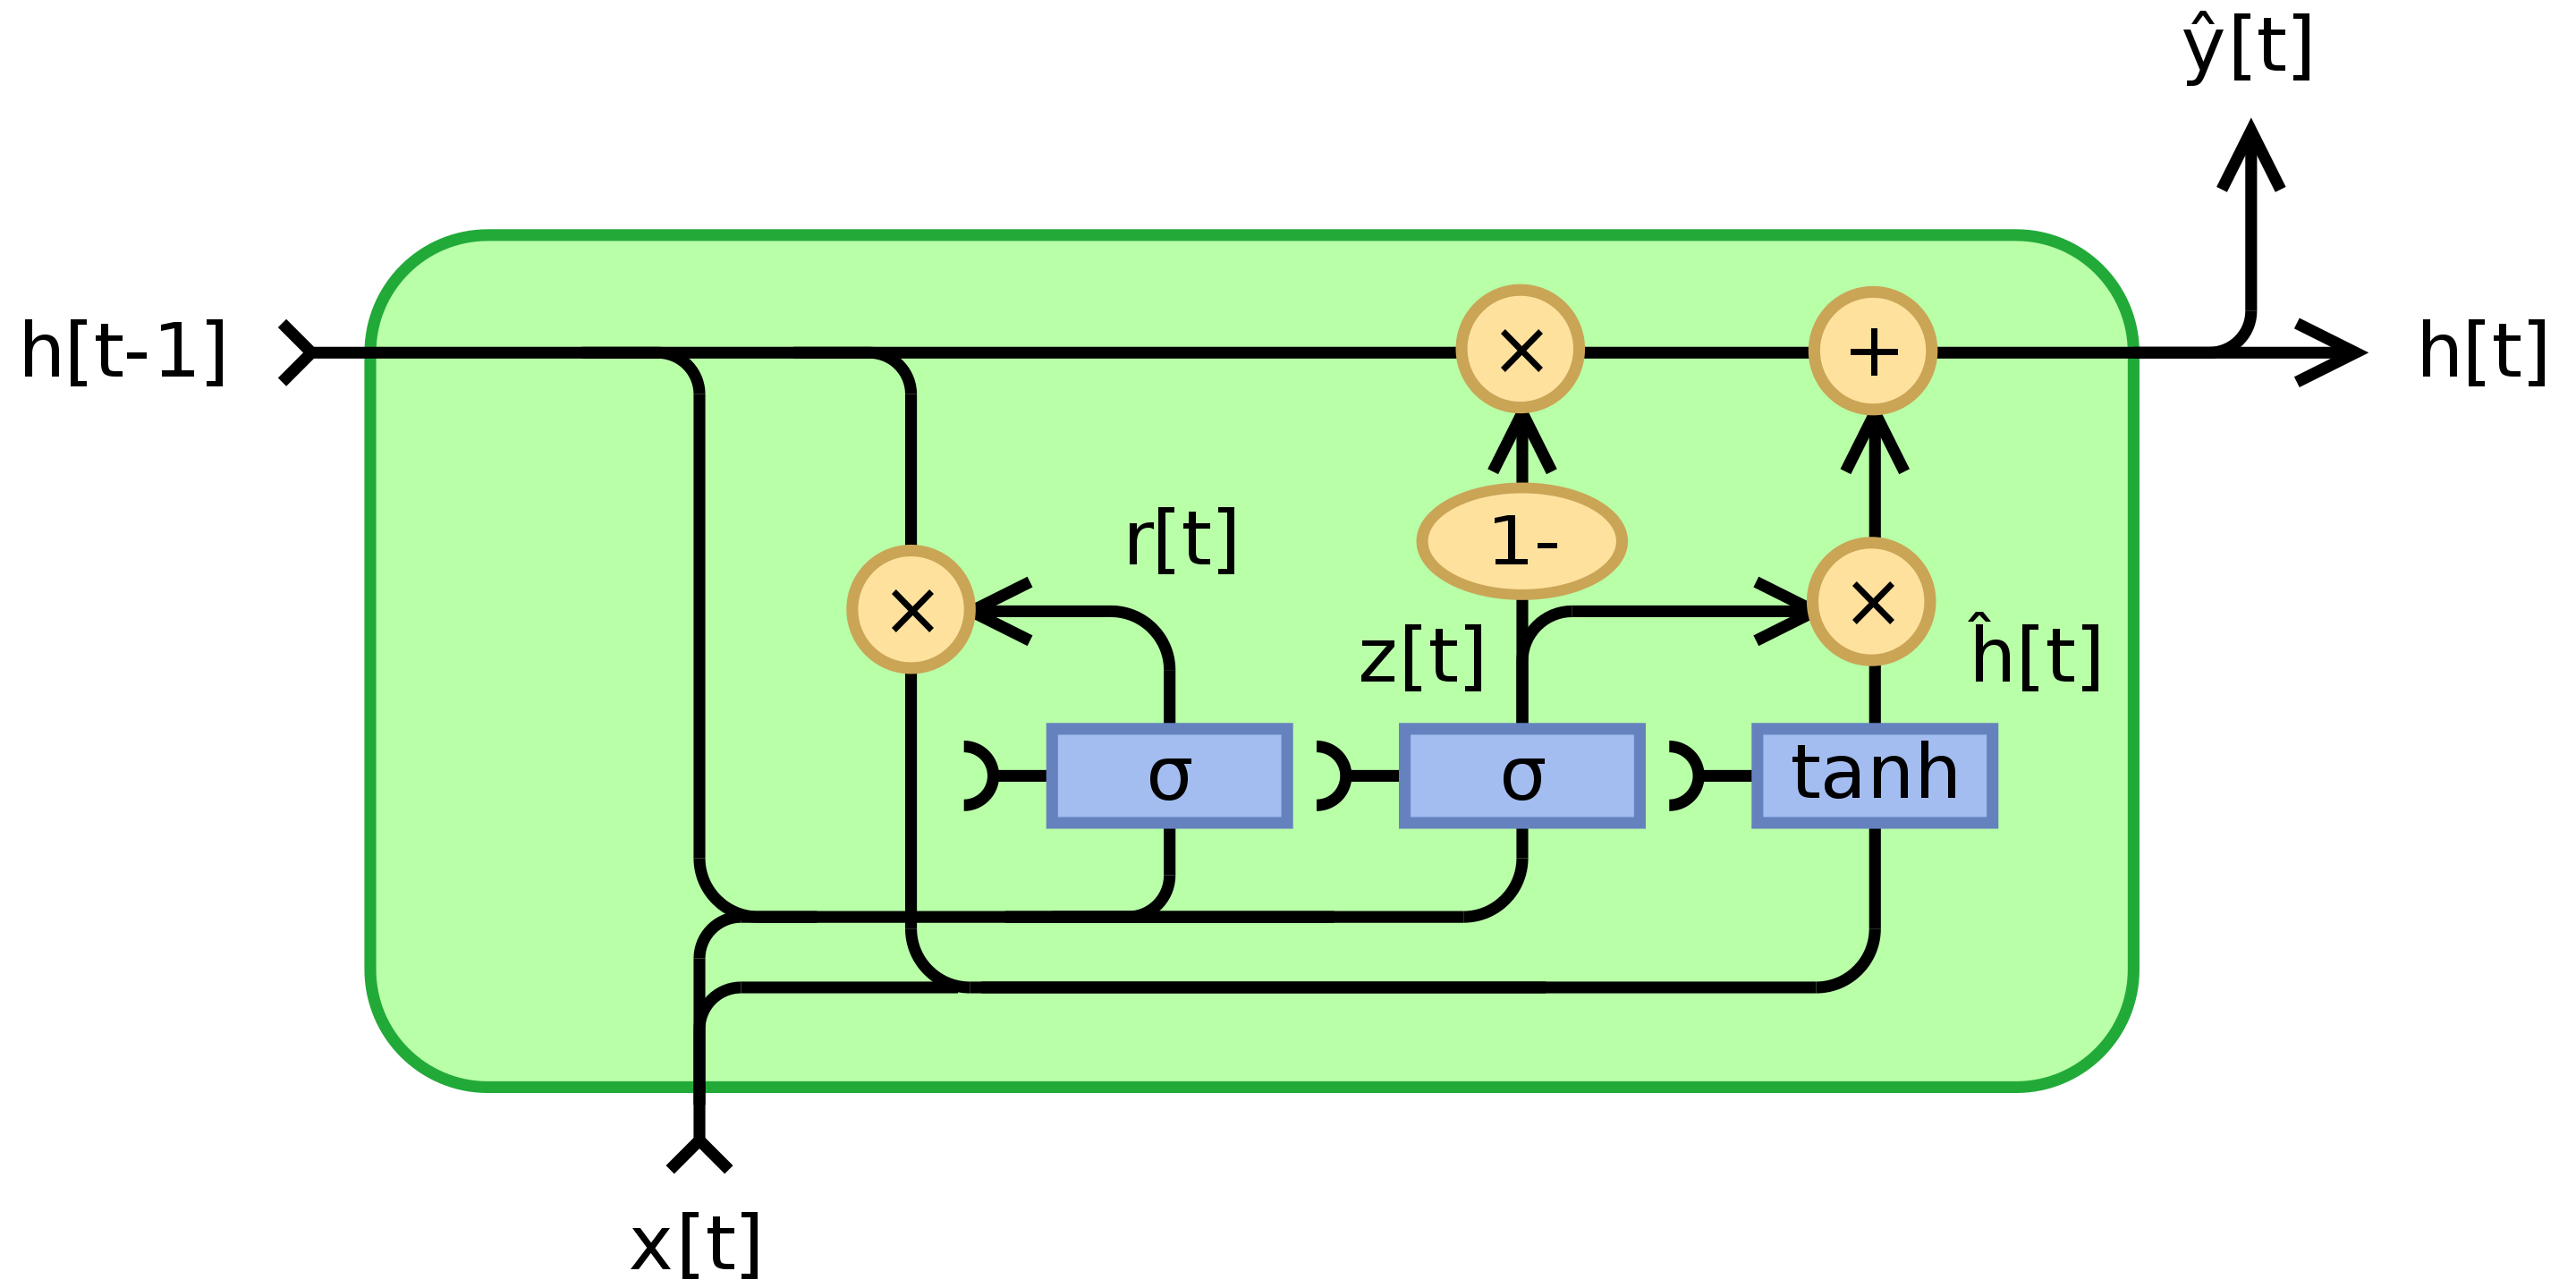

To learn more about GRU, please watch these short videos:

https://www.coursera.org/lecture/intro-to-deep-learning/modern-rnns-lstm-and-gru-WpduX

https://www.youtube.com/watch?v=pYRIOGTPRPU

Similar to the embedding layer, GRU module is not implemented in the Objax. The following is an implementation of the GRU cell in the Objax.

**Question 6[3 points]:** In the following implementation, complete the `__call__` function. 


1.   **update_gate**:
$z_t = \text{sigmoid} (W_z x_t + U_z h_{t-1} + b_z)$
2.   **reset_gate**:
$r_t = \text{sigmoid} (W_r x_t + U_r h_{t-1} + b_r)$
3.   **candidate activation vector:**
$\hat{h}_t = \text{tanh} (W_h x_t + U_h (r_t \odot h_{t-1}) + b_h)$
4.   **output_gate:**
$h_t =  (1-z_t)\odot h_{t-1} + z_t \odot \hat{h}_t$


In [7]:
class GRU(objax.Module):
    def __init__(self, nin: int, nout: int,
                 init_w: Callable = objax.nn.init.xavier_truncated_normal,
                 init_b: Callable = objax.nn.init.truncated_normal):
        self.update_w = objax.TrainVar(init_w((nin, nout)))
        self.update_u = objax.TrainVar(init_w((nout, nout)))
        self.update_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.reset_w = objax.TrainVar(init_w((nin, nout)))
        self.reset_u = objax.TrainVar(init_w((nout, nout)))
        self.reset_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.output_w = objax.TrainVar(init_w((nin, nout)))
        self.output_u = objax.TrainVar(init_w((nout, nout)))
        self.output_b = objax.TrainVar(init_b((nout,), stddev=0.01))

    def __call__(self, x: JaxArray, initial_state: JaxArray) -> Tuple[JaxArray, JaxArray]:
        def scan_op(state: JaxArray, x: JaxArray) -> JaxArray:  # State must come first for lax.scan
            # fill this in
            update_gate = objax.functional.sigmoid(jn.dot(x, self.update_w.value) + jn.dot(state, self.update_u.value) + self.update_b.value)

            # fill this in
            reset_gate = objax.functional.sigmoid(jn.dot(x, self.reset_w.value) + jn.dot(state, self.reset_u.value) + self.reset_b.value)
            
            # fill this in
            cand_actv_vec = objax.functional.tanh(jn.dot(x, self.output_w.value) + jn.dot(jn.multiply(reset_gate, state), self.output_u.value) + self.output_b.value)
            output_gate = jn.multiply((1 - update_gate), state) + jn.multiply(update_gate, cand_actv_vec)
                                     
            #return update_gate * state + (1 - update_gate) * output_gate, 0  # we don't use the output, return 0.
            return (1-update_gate) * state + (update_gate) * output_gate, 0   # we don't use the output, return 0.

        return lax.scan(scan_op, initial_state, x.transpose((1, 0, 2)))[0]

**Questions 7** (bonus)[5 points]: With an example, explain in detail what does lax.scan function do, and what it is useful for?

In [215]:
def example_math(carry_val, values):
  carry_val += values
  return carry_val, carry_val

values = np.array([1, 3, 5, 7, 9])
initial_val = 0
carry_val, results = lax.scan(example_math, initial_val, values)

print(carry_val)
print(results)

25
[ 1  4  9 16 25]


"lax.scan" function does looping while having carry over between loops. "lax.scan" takes in the function "scan_op", the previous carried over value "initial_state", and the input values that are input vectors "x". The function then returns the carry value and the cumulated values. 

The example above of "lax.scan" uses the function "example_math" with the initial value (previous carried value) as 0 and values of an array of integers. The function returns the final result of the cumalitive value of all values (25) and the accumalated values for each loop with [1, 3, 5, 7, 9] and initial value 0, resulting in [1 4 9 16 25]. e.g. 1 was accumalated with 0 and 1, 4 was accumalted with 1 and 3, 9 was accumalted with 4 and 5, 16 was accumalted with 9 and 7, 25 was finally accumalted with 15 and 9. 0(initial) + 1 --> 1, 1 + 3 --> 4, 4 + 5 --> 9, 9 + 7 --> 16, 16 + 9 --> 25(final). 

"lax.scan" is useful for recurrent neural networks as we can easily implement the carry over loops without the need of having a manual for loop for the carry over or any recursive calls to a function to implement the carry over.

# The classifier 

The structure of the proposed classifier is as follows:


*   The input is a vector whose elements are integers in the interval $\{$1,...,max_vocab$\}$ of length max_len. In fact input is the one-hot encoding of each review.
*    Then, the embedding layer converts this vector into a matrix of size (max_len,embedding_size).
* Then, we feed each row of this matrix into the GRU cell. The size of the output vector of the GRU is num_hidden_units_GRU.
*  The output of the GRU is feed into a fully-connected layer with num_hidden_units neurons and ReLU activation function.

* Finally, we have the output layer which is a fully-connected layer with two outputs corresponding to the positive or negative label.



**Question 8** [3 points]: implement the described classifier using `objax.nn.Sequential`.




In [216]:
# fill this in:
gru_rnn = objax.nn.Sequential([
    # Then, the embedding layer converts this vector into a matrix of size (max_len,embedding_size).
    Embed(max_len, embedding_size),
    # Then, we feed each row of this matrix into the GRU cell. The size of the output vector of the GRU is num_hidden_units_GRU.\
    GRU(embedding_size, num_hidden_units_GRU),
    # The output of the GRU is feed into a fully-connected layer with num_hidden_units neurons and ReLU activation function.
    objax.nn.Linear(num_hidden_units_GRU, num_hidden_units), objax.functional.relu,
    # Finally, we have the output layer which is a fully-connected layer with two outputs corresponding to the positive or negative label.
    objax.nn.Linear(num_hidden_units, 2) # 2 outputs (positive or negative label)
])

You can print the structure as well as the number of the parameters of the each layer using the following line of codes.

In [217]:
print(f'{" Network ":-^79}')
print(gru_rnn.vars())

----------------------------------- Network -----------------------------------
(Sequential)[0](Embed).w          6000 (200, 30)
(Sequential)[1](GRU).update_w      900 (30, 30)
(Sequential)[1](GRU).update_u      900 (30, 30)
(Sequential)[1](GRU).update_b       30 (30,)
(Sequential)[1](GRU).reset_w       900 (30, 30)
(Sequential)[1](GRU).reset_u       900 (30, 30)
(Sequential)[1](GRU).reset_b        30 (30,)
(Sequential)[1](GRU).output_w      900 (30, 30)
(Sequential)[1](GRU).output_u      900 (30, 30)
(Sequential)[1](GRU).output_b       30 (30,)
(Sequential)[2](Linear).b           60 (60,)
(Sequential)[2](Linear).w         1800 (30, 60)
(Sequential)[4](Linear).b            2 (2,)
(Sequential)[4](Linear).w          120 (60, 2)
+Total(14)                       13472


**Question 9** [3 points]: Draw the classifier architecture diagram. For GRU consider drawing the unrolled version. You do not need to draw the internal structure of the GRU. 

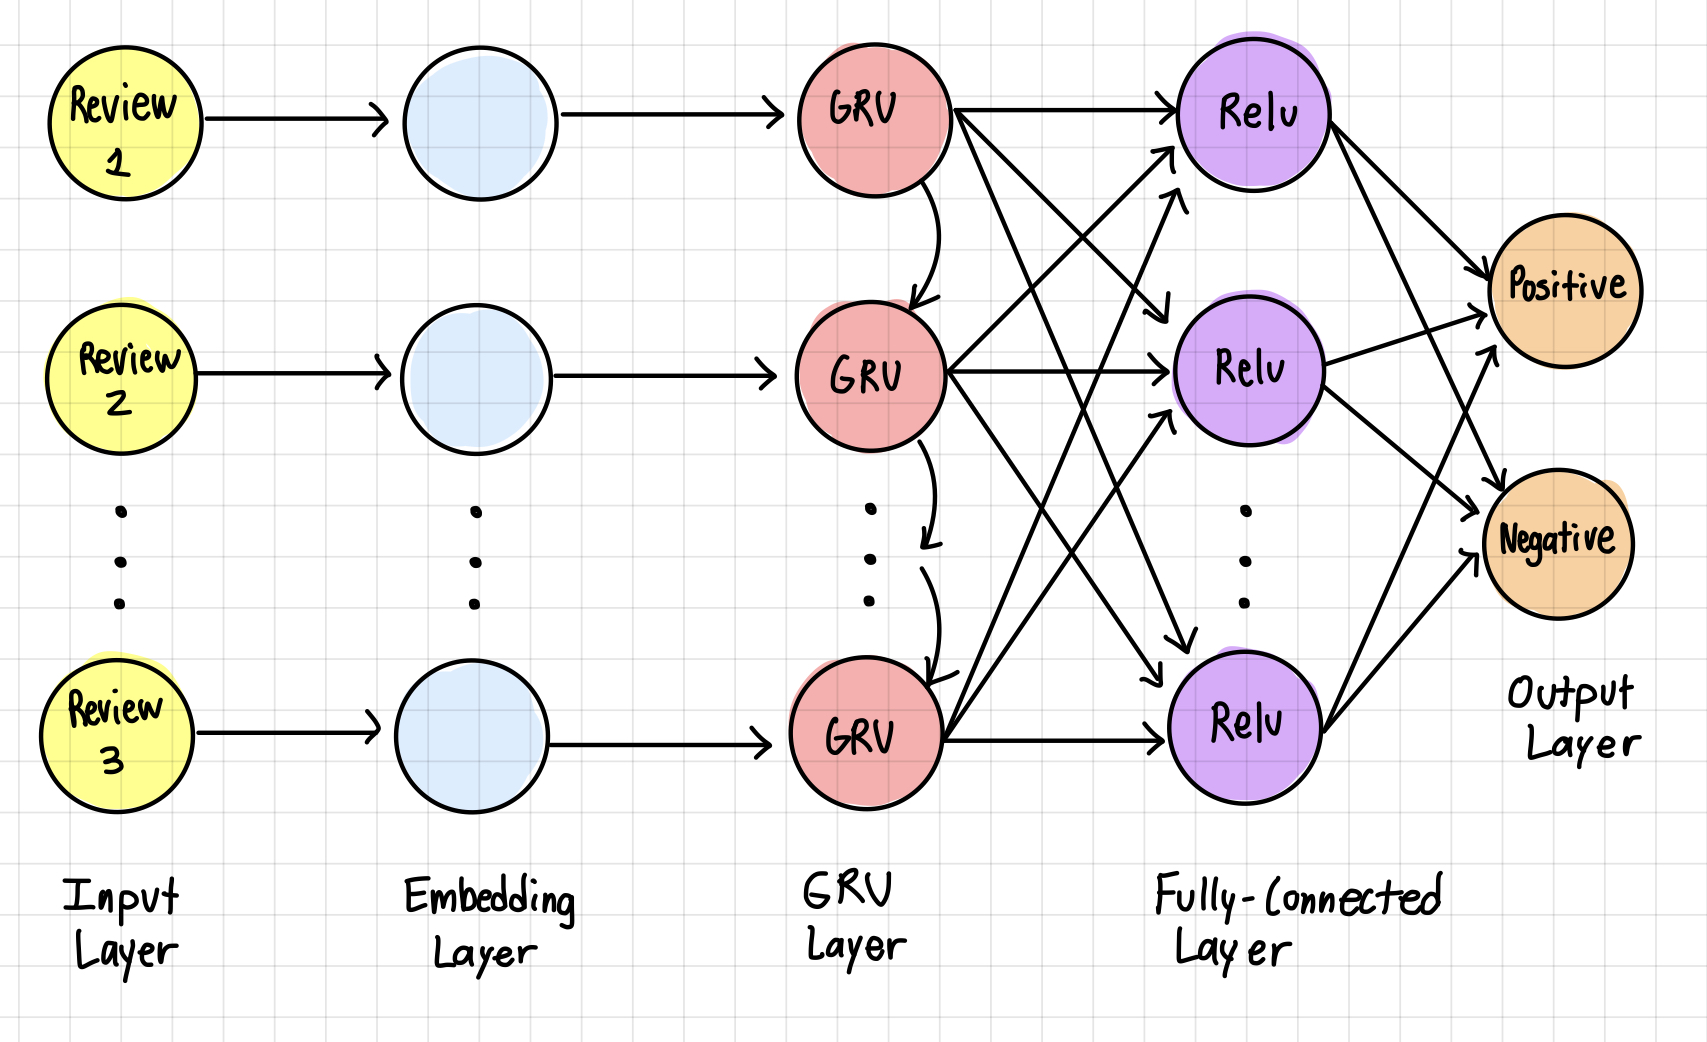

**Question 10**[1 point]: Construct an SGD optimizer using objax optimizers package.

In [218]:
## Your implementaiton of the optimizer should go here
# objax.optimizer.SGD(vc)
opt = objax.optimizer.SGD(gru_rnn.vars())

Then, we define the loss function, training operation function, and the
evaluation function.

In [219]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv = objax.GradValues(loss_function, gru_rnn.vars())


@objax.Function.with_vars(gv.vars() + opt.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv(x, y)
    opt(lr, g)
    return loss


train_op = objax.Jit(train_op)

eval_op = objax.Jit(lambda x: gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn.vars())


The next function is a helper for computing the accuracy.

In [8]:
def accuracy(data_loader):
    """Compute the accuracy for a provided data loader"""
    acc_total = 0
    x, y = data_loader
    batch_size_acc = 250
    for batch_idx in np.array_split(np.arange(len(x)), len(x) // batch_size_acc):
        x_batch, target_class = x[batch_idx], y[batch_idx]
        predicted_class = eval_op(x_batch).argmax(1)
        acc_total += (predicted_class == target_class).sum()
    return acc_total / len(x)

**Question 11** [4 points]: Write the training loop to train the model. In each epoch, record the training accuracy and the validation accuracy. Also, at the end of the training report the accuracy on the test set. Please use the training set to train the model, the validation set to monitor accuracy during training, and then the test set once after training is complete to measure the final generalization of the model.

In [178]:
learning_rate = 1e-3 # learning rate
num_epochs = 20 # number of epochs
batch_size = 250  # batch size

training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [179]:
X_train = training_data[0]
Y_train = training_data[1]

X_valid = validation_data[0]
Y_valid = validation_data[1]

In [155]:
# you code for the training loop should start here 
def train(EPOCHS = num_epochs, BATCH = batch_size, LEARNING_RATE = learning_rate):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it : it+BATCH] 
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = eval_op(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it : it+BATCH] 
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = eval_op(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  # Reporting the Accuracy on Test Set

  print('Test Accuracy %.2f' % (100*accuracy(test_data)))

  # For Plotting purposes
  return (train_acc_epoch, val_acc_epoch)

In [156]:
train_acc_epoch, val_acc_epoch = train()

Epoch 0001  Training Loss 173.11 Validation Loss 172.57 Training Accuracy 53.21 Validation Accuracy 55.50
Epoch 0002  Training Loss 172.45 Validation Loss 171.24 Training Accuracy 55.32 Validation Accuracy 56.80
Epoch 0003  Training Loss 170.65 Validation Loss 166.84 Training Accuracy 58.08 Validation Accuracy 60.58
Epoch 0004  Training Loss 167.81 Validation Loss 162.19 Training Accuracy 59.66 Validation Accuracy 62.60
Epoch 0005  Training Loss 164.73 Validation Loss 159.44 Training Accuracy 61.28 Validation Accuracy 64.54
Epoch 0006  Training Loss 162.27 Validation Loss 151.27 Training Accuracy 63.82 Validation Accuracy 67.98
Epoch 0007  Training Loss 158.75 Validation Loss 148.03 Training Accuracy 65.25 Validation Accuracy 69.50
Epoch 0008  Training Loss 155.29 Validation Loss 146.15 Training Accuracy 66.84 Validation Accuracy 70.68
Epoch 0009  Training Loss 150.97 Validation Loss 139.09 Training Accuracy 68.83 Validation Accuracy 72.34
Epoch 0010  Training Loss 143.06 Validation Lo

**Question 12:[1 points]**  Plot the training accuracy and the validation accuracy versus the number of epochs. What is the generalization gap between the test and training?

In [157]:
def plot():
  #Plot training accuracy and validation accuracy vs. epoch
  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

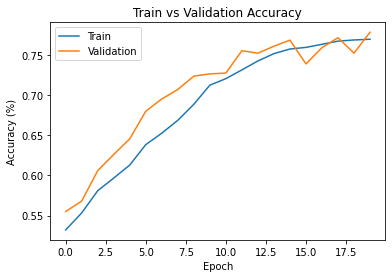

0.0013250113


In [158]:
plot()

print(accuracy(test_data) - train_acc_epoch[19])

The Generalization Gap between the Test and Training is 0.0013250113

# Comparing SGD with Adam

**Question 13** [4 points]: Train the same model with the same parameters using the Adam optimizer instead of the SGD. Do not forgot to initialize the network before training, otherwise the previous model will continue training from the final model parameters rather than start from a fresh set of random weight initialization values.

In [8]:
# Define (again) your model here
gru_rnn2 = objax.nn.Sequential([
   # Then, the embedding layer converts this vector into a matrix of size (max_len,embedding_size).
    Embed(max_len, embedding_size),
    # Then, we feed each row of this matrix into the GRU cell. The size of the output vector of the GRU is num_hidden_units_GRU.\
    GRU(embedding_size, num_hidden_units_GRU),
    # The output of the GRU is feed into a fully-connected layer with num_hidden_units neurons and ReLU activation function.
    objax.nn.Linear(num_hidden_units_GRU, num_hidden_units), objax.functional.relu,
    # Finally, we have the output layer which is a fully-connected layer with two outputs corresponding to the positive or negative label.
    objax.nn.Linear(num_hidden_units, 2) # 2 outputs (positive or negative label)
])

In [222]:
## Your implementaiton of the optimizer should go here
# objax.optimizer.Adam(vc)
opt2 = objax.optimizer.Adam(gru_rnn2.vars())

You will also need the following functions.

In [223]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv2 = objax.GradValues(loss_function, gru_rnn2.vars())


@objax.Function.with_vars(gv2.vars() + opt2.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv2(x, y)
    opt2(lr, g)
    return loss


train_op = objax.Jit(train_op)

eval_op = objax.Jit(lambda x: gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn2.vars())

In [224]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250 

training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [225]:
X_train = training_data[0]
Y_train = training_data[1]

X_valid = validation_data[0]
Y_valid = validation_data[1]

In [226]:
# you code for the training loop should start here 
def train_ADAM(EPOCHS = num_epochs, BATCH = batch_size, LEARNING_RATE = learning_rate):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it : it+BATCH] 
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = eval_op(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it : it+BATCH] 
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = eval_op(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  # Reporting the Accuracy on Test Set

  print('Test Accuracy %.2f' % (100*accuracy(test_data)))

  # For Plotting purposes
  return (train_acc_epoch, val_acc_epoch)


In [227]:
train_acc_epoch, val_acc_epoch = train_ADAM()

Epoch 0001  Training Loss 152.40 Validation Loss 124.85 Training Accuracy 65.59 Validation Accuracy 76.12
Epoch 0002  Training Loss 127.92 Validation Loss 122.15 Training Accuracy 75.31 Validation Accuracy 76.90
Epoch 0003  Training Loss 127.99 Validation Loss 126.07 Training Accuracy 74.99 Validation Accuracy 74.62
Epoch 0004  Training Loss 128.40 Validation Loss 129.73 Training Accuracy 75.00 Validation Accuracy 74.08
Epoch 0005  Training Loss 130.03 Validation Loss 127.95 Training Accuracy 74.14 Validation Accuracy 74.54
Epoch 0006  Training Loss 129.38 Validation Loss 125.82 Training Accuracy 74.35 Validation Accuracy 75.20
Epoch 0007  Training Loss 126.00 Validation Loss 124.71 Training Accuracy 75.41 Validation Accuracy 75.46
Epoch 0008  Training Loss 124.27 Validation Loss 121.52 Training Accuracy 75.63 Validation Accuracy 76.54
Epoch 0009  Training Loss 122.13 Validation Loss 120.45 Training Accuracy 76.38 Validation Accuracy 76.86
Epoch 0010  Training Loss 121.25 Validation Lo

**Question 14** [1 points]: Plot the training accuracy and validation accuracy versus the epochs, and compare your results with the case that you trained the network using SGD. What is the generalization gap for this case?

In [203]:
def plot():
  #Plot training accuracy and validation accuracy vs. epoch
  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

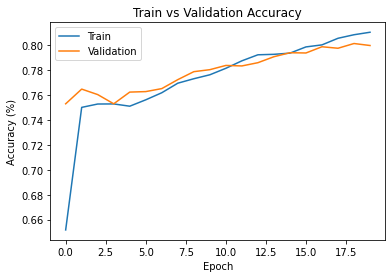

-0.006850004


In [204]:
plot()

print(accuracy(test_data) - train_acc_epoch[19])

The Generalization Gap between the Test and Training is 0.006850004. The Adam has higher Test Accuracy, Validation Accuracy, and Training Accuracy than the trained network using SGD.

**Questions 15** [1 points]: Briefly explain how Adam optimizer works and compare it with the SGD optimizaer.

Adam optimizer works by considering the exponentially weighted average of the gradients and taking the exponential moving average rather than the cumalitive sum of squared gradients. Compared to the SGD optimizer where the learning rate is static during weight updats, the Adam optimizer computes adaptive learning rates for each network weight parameters as it learns.

# Early Stopping

**Questions 16** [3 points]: 
This time implement the early stopping method with a patience window. All the parameters are the same as the previous section. Also, set the patience window to 5 epochs.

In [9]:
# Your implementation of the model should go here
gru_rnn3 = objax.nn.Sequential([
   # Then, the embedding layer converts this vector into a matrix of size (max_len,embedding_size).
    Embed(max_len, embedding_size),
    # Then, we feed each row of this matrix into the GRU cell. The size of the output vector of the GRU is num_hidden_units_GRU.\
    GRU(embedding_size, num_hidden_units_GRU),
    # The output of the GRU is feed into a fully-connected layer with num_hidden_units neurons and ReLU activation function.
    objax.nn.Linear(num_hidden_units_GRU, num_hidden_units), objax.functional.relu,
    # Finally, we have the output layer which is a fully-connected layer with two outputs corresponding to the positive or negative label.
    objax.nn.Linear(num_hidden_units, 2) # 2 outputs (positive or negative label)
])

In [10]:
## Your implementaiton of the optimizer should go here
# objax.optimizer.Adam(vc)
opt3 = objax.optimizer.Adam(gru_rnn3.vars())

You will also need the following functions.

In [11]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv3 = objax.GradValues(loss_function, gru_rnn3.vars())


@objax.Function.with_vars(gv3.vars() + opt3.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv3(x, y)
    opt3(lr, g)
    return loss


train_op = objax.Jit(train_op)

eval_op = objax.Jit(lambda x: gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn3.vars())

In [12]:
def accuracy(data_loader):
    """Compute the accuracy for a provided data loader"""
    acc_total = 0
    x, y = data_loader
    batch_size_acc = 250
    for batch_idx in np.array_split(np.arange(len(x)), len(x) // batch_size_acc):
        x_batch, target_class = x[batch_idx], y[batch_idx]
        predicted_class = eval_op(x_batch).argmax(1)
        acc_total += (predicted_class == target_class).sum()
    return acc_total / len(x)

In [13]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250 
max_patience_window = 5

training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [14]:
X_train = training_data[0]
Y_train = training_data[1]

X_valid = validation_data[0]
Y_valid = validation_data[1]

In [15]:
# you code for the training loop should start here 
def train_ADAM_Early(EPOCHS = num_epochs, BATCH = batch_size, LEARNING_RATE = learning_rate, PATIENCE = max_patience_window):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  wait = 0
  best = 0

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it : it+BATCH] 
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = eval_op(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it : it+BATCH] 
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = eval_op(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      #Early Stopping
      wait += 1
      if avg_val_loss > best:
        best = avg_val_loss
        wait = 0
      if wait >= PATIENCE:
        break

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  # Reporting the Accuracy on Test Set

  print('Test Accuracy %.2f' % (100*accuracy(test_data)))

  # For Plotting purposes
  return (train_acc_epoch, val_acc_epoch)


In [16]:
train_acc_epoch, val_acc_epoch = train_ADAM_Early()

Epoch 0001  Training Loss 152.40 Validation Loss 124.88 Training Accuracy 65.58 Validation Accuracy 76.12
Epoch 0002  Training Loss 127.92 Validation Loss 122.14 Training Accuracy 75.33 Validation Accuracy 76.84
Epoch 0003  Training Loss 128.00 Validation Loss 125.23 Training Accuracy 75.00 Validation Accuracy 75.08
Epoch 0004  Training Loss 128.37 Validation Loss 129.91 Training Accuracy 74.96 Validation Accuracy 73.90
Epoch 0005  Training Loss 130.02 Validation Loss 127.79 Training Accuracy 74.11 Validation Accuracy 74.64
Epoch 0006  Training Loss 129.34 Validation Loss 125.81 Training Accuracy 74.39 Validation Accuracy 75.30
Epoch 0007  Training Loss 126.03 Validation Loss 124.81 Training Accuracy 75.42 Validation Accuracy 75.48
Epoch 0008  Training Loss 124.31 Validation Loss 121.54 Training Accuracy 75.62 Validation Accuracy 76.44
Test Accuracy 76.30


In [17]:
def plot():
  #Plot training accuracy and validation accuracy vs. epoch
  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

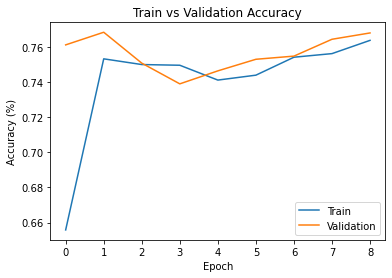

0.0067750216


In [18]:
plot()

print(accuracy(test_data) - train_acc_epoch[7])

**Question 17**[1 points]: Report the best validation accuracy and the test accuracy of your best model.

gru_rnn with SGD optimizer:

Best Validation Accuracy - 77.80%

Best Test Accuracy - 77.06%



---


gru_rnn2 with Adam optimizer

Best Validation Accuracy - 80.14%

Best Test Accuracy - 80.36%


---



gru_rnn3 with Adam optimizer and Early Stopping:

Best Validation Accuracy - 76.87%

Best Test Accuracy - 76.30%


---

The Best Model is the gru_rnn2 that used the Adam optimizer without Early Stopping.